### Message Passing for REFLACX graph datapoints

In [1]:
import torch
import dgl.function as fn
import dgl
import matplotlib.pyplot as plt
import numpy as np


from iou_graph import IOUGraph
from dgl_reflacx_tools.tools import get_node, get_edge, draw, get_connected_component
from dgl_reflacx_tools.dgl_reflacx_collection import GraphCollection

/home/antonio/dev/pyvenvs/graph_classification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_pth = 'datasets/reflacx_densnet225_iou'

In [3]:
collection = GraphCollection(dataset_pth, IOUGraph)

loading metadata
metadata loaded from file
Done loading data from cached files.


In [4]:
pair = collection.fetch_by_reflacx('1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb', 'P300R510107')

1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb -- P300R510107 
  Fixation 13 out of chest bounding box

1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb -- P300R510107 
  Fixation 14 out of chest bounding box

1bdf3180-0209f001-967acab6-0b811ea2-3c2e13eb -- P300R510107 
  Fixation 60 out of chest bounding box



In [5]:
g = pair.dgl_graph
labels = pair.dgl_labels
g, labels

(Graph(num_nodes=60, num_edges=204,
       ndata_schemes={'feats': Scheme(shape=(1024,), dtype=torch.float32), 'duration': Scheme(shape=(), dtype=torch.float32), 'norm_bottom_right': Scheme(shape=(2,), dtype=torch.float32), 'norm_top_left': Scheme(shape=(2,), dtype=torch.float32), 'norm_y': Scheme(shape=(), dtype=torch.float32), 'norm_x': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}),
 tensor([1., 0., 1., 0., 0., 1.]))

In [6]:
if torch.cuda.device_count() > 0:
    g = g.to(torch.device('cuda:0'))
    labels = labels.to(torch.device('cuda:0'))
g, labels, g.nodes().device, labels.device

(Graph(num_nodes=60, num_edges=204,
       ndata_schemes={'feats': Scheme(shape=(1024,), dtype=torch.float32), 'duration': Scheme(shape=(), dtype=torch.float32), 'norm_bottom_right': Scheme(shape=(2,), dtype=torch.float32), 'norm_top_left': Scheme(shape=(2,), dtype=torch.float32), 'norm_y': Scheme(shape=(), dtype=torch.float32), 'norm_x': Scheme(shape=(), dtype=torch.float32)}
       edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)}),
 tensor([1., 0., 1., 0., 0., 1.], device='cuda:0'),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

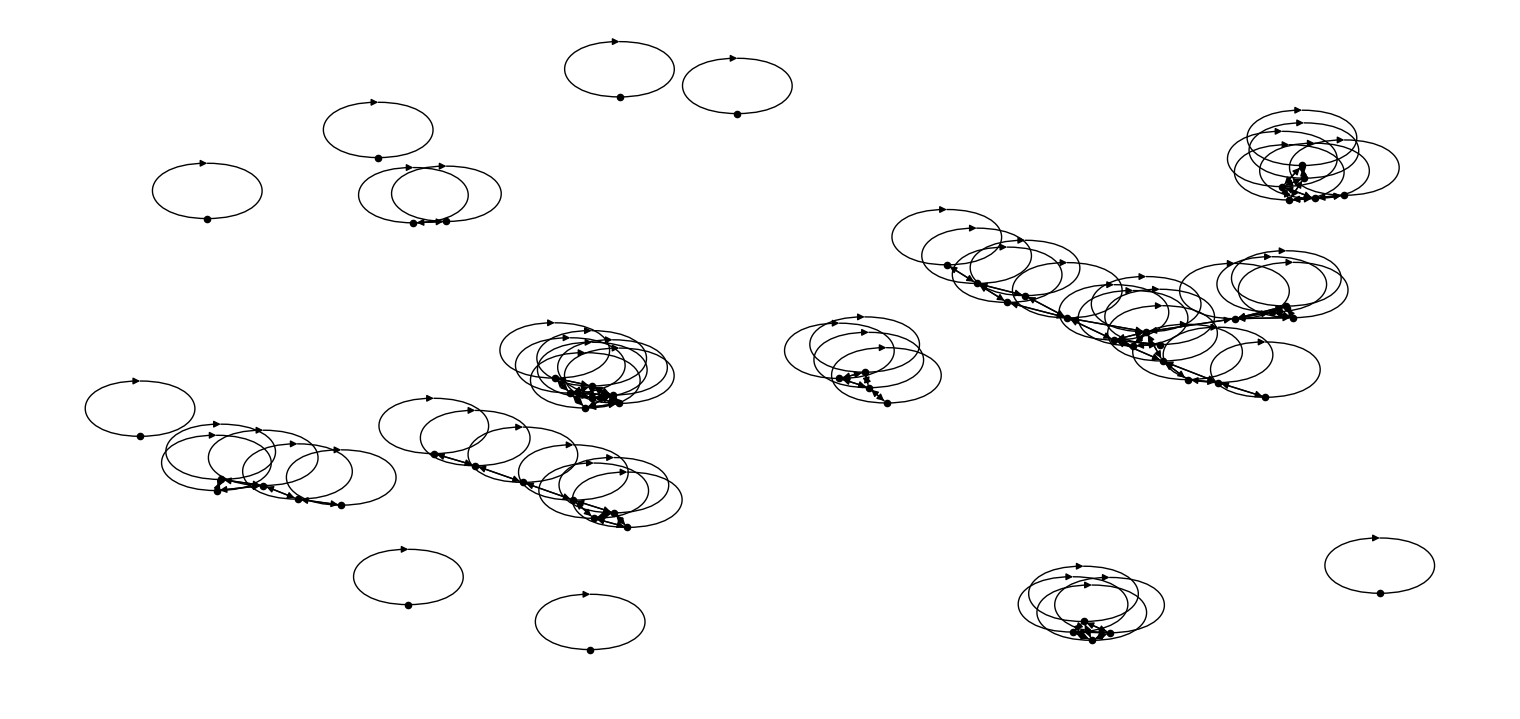

In [7]:
draw(g)

In [8]:
def node_edge_fns(g):
    node = lambda i: get_node(g, i)
    edge = lambda i, j: get_edge(g, i, j)
    return node, edge

In [9]:
adj = g.adjacency_matrix().to_dense().cpu().detach().numpy()

In [10]:
cc = get_connected_component(np.copy(adj))

In [11]:
sg = g.subgraph(list(cc))

In [12]:
dgl.mean_nodes(sg, 'feats').shape

torch.Size([1, 1024])

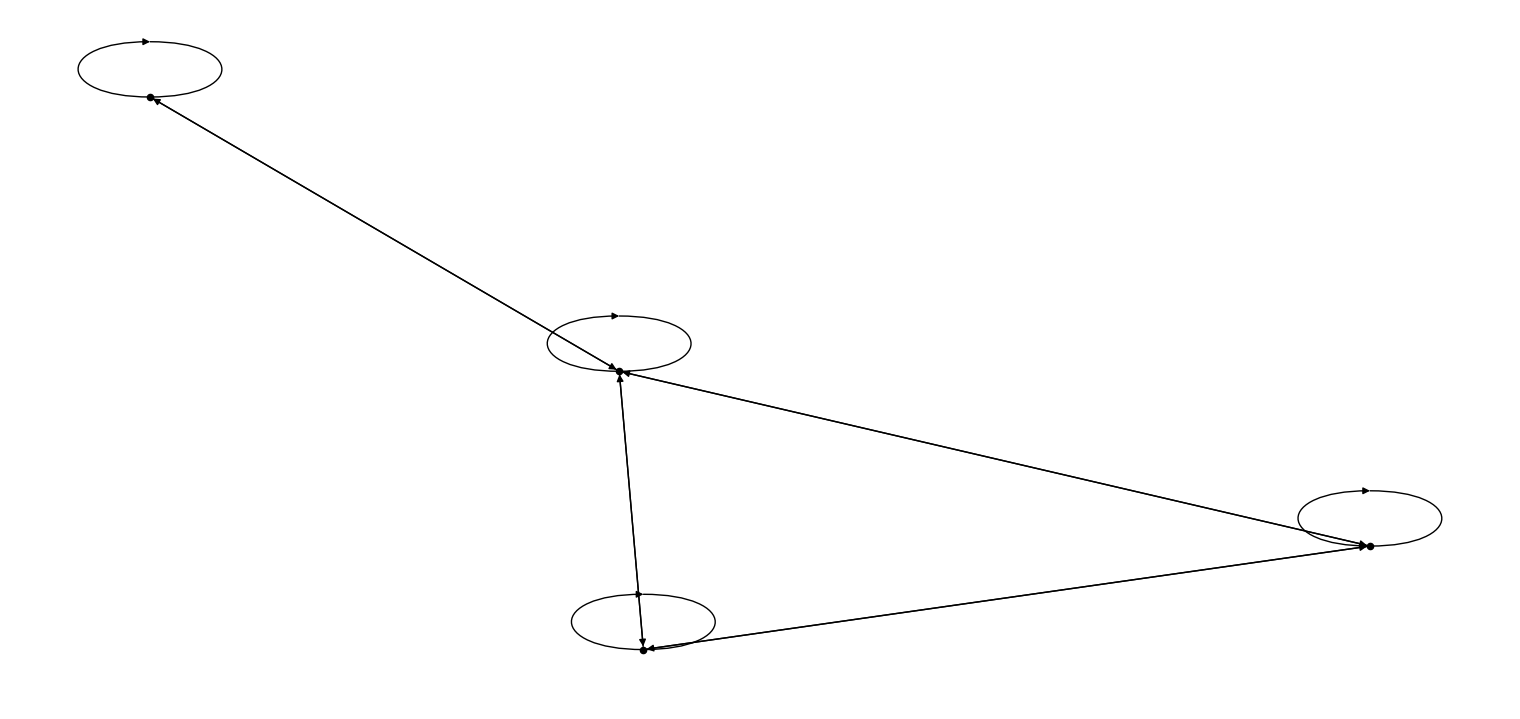

In [13]:
draw(sg)

In [14]:
def print_keys(keys):
    for k in keys:
        print(k)

In [15]:
print_keys(sg.edata.keys())

weight
_ID


In [16]:
print_keys(sg.ndata.keys())

feats
duration
norm_bottom_right
norm_top_left
norm_y
norm_x
_ID


Setting neighborhood weight factors for duration and IOU

In [ ]:
def init_gnn(g):
    g.apply_edges(fn.u_mul_e('duration', 'weight', 'factor'))
    g.update_all(fn.copy_e('factor', 'm'), fn.sum('m', 'neigh_factor'))

init_gnn(sg)

convolution step 1

In [ ]:
def conv_1(g):
    g.apply_edges(fn.u_mul_e('feats', 'factor', 'w_feats'))
    g.update_all(fn.e_div_v('w_feats', 'neigh_factor', 'norm_feats'),
                  fn.sum('norm_feats', 'conv_feats'))

conv_1(sg)

convolution steps 2 and on

In [ ]:
def conv_2n(g):
    g.apply_edges(fn.u_mul_e('conv_feats', 'factor', 'w_feats'))
    g.update_all(fn.e_div_v('w_feats', 'neigh_factor', 'norm_feats'),
                 fn.sum('norm_feats', 'conv_feats'))

conv_2n(sg)

testing execution time for largest graph

In [ ]:
metadata = collection.reflacx

In [ ]:
max_pt = None
max_len = 0
for d in metadata.list_dicom_ids():
    for r in metadata.list_reflacx_ids(d):
        pt = metadata.get_sample(d, r)
        l = len(pt.get_fixations())
        if max_pt is None or l > max_len:
            max_len = l
            max_pt = pt

In [ ]:
max_len

In [ ]:
d, r = max_pt.dicom_id, max_pt.reflacx_id
d, r

In [ ]:
d = '5d93b668-2ecb804a-0b026b1d-08c7dd4d-0bd8202c'
r = 'P300R591856'

In [ ]:
pair = collection.fetch_by_reflacx(d, r)
g = pair.dgl_graph
labels = pair.dgl_labels
g, labels

In [ ]:
print_keys(g.edata.keys())

In [ ]:
print_keys(g.ndata.keys())

In [ ]:
from time import time

In [ ]:
clock = time()
init_gnn(g)
init_t = time() - clock
clock = time()
conv_1(g)
conv_1_t = time() - clock
clock = time()
conv_2n(g)
conv_2n_t = time() - clock

In [ ]:
init_t, conv_1_t, conv_2n_t

### Aggregating graph into grid
making a subgraph for each grid cell, limited by x and y

In [17]:
node, edge = node_edge_fns(g)

In [18]:
node(0)

{'feats': tensor([-0.0015, -0.0672, -0.3450,  ..., -0.2739, -1.1014, -1.0111],
        device='cuda:0'),
 'duration': tensor(0.1460, device='cuda:0'),
 'norm_bottom_right': tensor([0.7156, 0.6114], device='cuda:0'),
 'norm_top_left': tensor([0.6188, 0.4809], device='cuda:0'),
 'norm_y': tensor(0.5461, device='cuda:0'),
 'norm_x': tensor(0.6672, device='cuda:0')}

In [19]:
from dgl_reflacx_tools.tools import gridify, grid_readout

In [20]:
sg_grid = gridify(g, 4)
sg_grid[0]

[Graph(num_nodes=0, num_edges=0,
       ndata_schemes={'feats': Scheme(shape=(1024,), dtype=torch.float32), 'duration': Scheme(shape=(), dtype=torch.float32), 'norm_bottom_right': Scheme(shape=(2,), dtype=torch.float32), 'norm_top_left': Scheme(shape=(2,), dtype=torch.float32), 'norm_y': Scheme(shape=(), dtype=torch.float32), 'norm_x': Scheme(shape=(), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=2, num_edges=2,
       ndata_schemes={'feats': Scheme(shape=(1024,), dtype=torch.float32), 'duration': Scheme(shape=(), dtype=torch.float32), 'norm_bottom_right': Scheme(shape=(2,), dtype=torch.float32), 'norm_top_left': Scheme(shape=(2,), dtype=torch.float32), 'norm_y': Scheme(shape=(), dtype=torch.float32), 'norm_x': Scheme(shape=(), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'weight': Scheme(sh

In [79]:
duration_ro = grid_readout(sg_grid, 'duration', lambda x, y: dgl.sum_nodes(x, y).cpu())
duration_ro.shape

torch.Size([4, 4])

In [66]:
grad = torch.zeros_like(duration_ro)
grad[:, :] = 2.0
duration_ro.grad = grad

In [80]:
feats_ro = grid_readout(sg_grid, 'feats', lambda x, y: dgl.mean_nodes(x, y).cpu())
feats_ro.shape

torch.Size([4, 4, 1024])

In [68]:
grad = torch.zeros_like(feats_ro)
grad[:, :] = 3.0
feats_ro.grad = grad
feats_ro.grad

tensor([[[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.],
         [3., 3., 3.,  ..., 3., 3., 3.]]])

In [81]:
fs = torch.cat((torch.unsqueeze(duration_ro, 2), feats_ro), 2)
fs.shape

torch.Size([4, 4, 1025])

In [84]:
fs[:, :, 1] == feats_ro[:, :, 0]

tensor([[False,  True,  True,  True],
        [ True,  True,  True, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [86]:
fs[1, 3, 1], feats_ro[1, 3, 0]

(tensor(nan), tensor(nan))

In [92]:
node(3)['feats'].shape

torch.Size([1024])

In [109]:
x = torch.randn(3)
y = torch.randn(3)
x, y

(tensor([-0.1167,  0.1154,  0.0761]), tensor([ 1.1417, -0.2387,  1.4677]))

In [111]:
z = torch.cat((x.unsqueeze(0), y.unsqueeze(0)), 0)

In [119]:
torch.cat((z, x.unsqueeze(0)), 0)

tensor([[-0.1167,  0.1154,  0.0761],
        [ 1.1417, -0.2387,  1.4677],
        [-0.1167,  0.1154,  0.0761]])